In [1]:
import glob
import os
import sys
import time

import cv2
import numpy as np
import png
from matplotlib import pyplot as plt
from matplotlib import cm, colors

from ip_basic import depth_map_utils
from ip_basic import vis_utils

In [2]:
input_dir = "/media/bigdrive/cecilia/datasets/cityscapes/disparity/"
output_dir = "/media/bigdrive/cecilia/datasets/cityscapes/completed_depth"
mode = "fast_bilateral"

In [3]:
##############################
# Options
##############################

# Fast fill with Gaussian blur @90Hz (paper result)
if mode == "gaussian":
    fill_type = 'fast'
    extrapolate = True
    blur_type = 'gaussian'

# Fast Fill with bilateral blur, no extrapolation @87Hz (recommended)
elif mode == "fast_bilateral":
    fill_type = 'fast'
    extrapolate = False
    blur_type = 'bilateral'

# Multi-scale dilations with extra noise removal, no extrapolation @ 30Hz
elif mode == "multiscale_bilateral":
    fill_type = 'multiscale'
    extrapolate = False
    blur_type = 'bilateral'

else:
    raise ValueError("Mode not implemented: " + mode)

In [4]:
def disparity_to_depth(disparity_path):
    disparity_arr = cv2.imread(disparity_path, cv2.IMREAD_ANYDEPTH)
    # Conversion from https://github.com/mcordts/cityscapesScripts see `disparity`
    # See https://github.com/mcordts/cityscapesScripts/issues/55#issuecomment-411486510
    disparity_arr[disparity_arr > 0] = (disparity_arr[disparity_arr > 0] - 1.0) / 256.
    depth_arr = np.zeros(disparity_arr.shape)
    depth_arr[disparity_arr > 0] = 0.2 * 2262 / disparity_arr[disparity_arr > 0]
    return depth_arr

In [5]:
def display(img):
    
    cmap: colors.Colormap = cm.get_cmap("jet")
    norm: colors.Normalize = colors.Normalize()
    # set min and max values from data
    norm.autoscale(img[img>0])

    # move scalar values to range [0, 1]
    # can skip and pass directly to cmap if data already [0, 1]
    normalised = norm(img)

    # create a RBGA array
    # bytes=True gives a uint8 array (Unsigned integer 0 to 255)
    data_rgba = cmap(normalised, bytes=True)
    # masks -1 values with white 
    data_rgba[np.tile(np.expand_dims(img, axis=2), [1,1,4]) == 0] = 255
    plt.matshow(data_rgba)
    plt.colorbar()
    plt.show()
    return data_rgba

In [6]:
# Get images in sorted order
images_to_use = sorted(glob.glob(input_dir + '/*/*/*.png'))

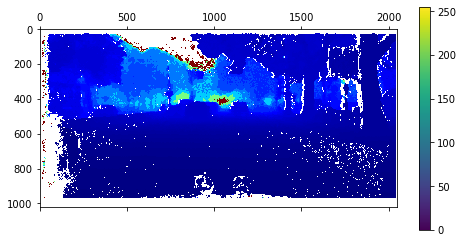

In [7]:
vis = display(disparity_to_depth(images_to_use[0]))

In [8]:
def subsample(img, dropout=0.05):
    n = int(img.shape[0]*img.shape[1])
    index = np.random.choice(n, int(np.floor(n*dropout)), replace=False)
    img.flat[index] = 0
    return img

In [9]:
org = disparity_to_depth(images_to_use[0])
img = subsample(org, dropout=0.25)

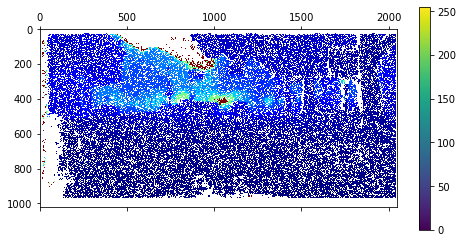

In [10]:
vis = display(img)


In [11]:
final_depths = depth_map_utils.fill_in_fast(
                img.astype(np.uint8), extrapolate=extrapolate, blur_type=blur_type)

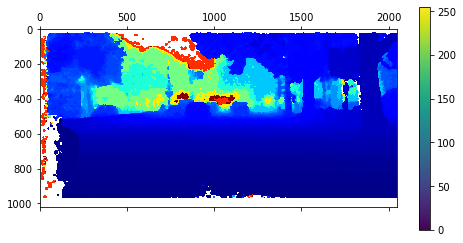

In [12]:
vis = display(final_depths)

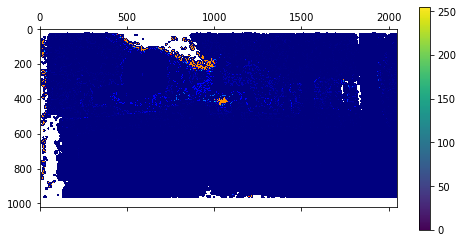

In [13]:
vis = display(org-final_depths)

In [19]:
error = np.abs(org-final_depths)
error[org==0] = 0
ave_error = np.sum(error)/np.count_nonzero(org)

print(np.sum(error))
print(ave_error)

5251642.249294689
4.072397969318989
5251642.249294689
4.072397969318989
